In [1]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime

# Load the CSV file using pandas
df = pd.read_csv('train.csv')

# Extract the label column and convert to a PyTorch tensor
ids = torch.tensor(df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
store_nbr = torch.tensor(df['store_nbr'].values)
train_sales = torch.tensor(df['sales'].values, dtype=torch.float)
onpromotion = torch.tensor(df['onpromotion'].values)

# Convert string dates to datetime objects
dates = pd.to_datetime(df['date'], format='%Y-%m-%d')
#I suppose that day of week is important to predict sales
day_of_week = dates.dt.weekday + 1
day_of_week = torch.from_numpy(day_of_week.to_numpy())
day_of_week = day_of_week.type(torch.float32)

day_of_month = dates.dt.day
day_of_month = torch.from_numpy(day_of_month.to_numpy())
day_of_month = day_of_month.type(torch.float32)
day_since_paycheck = []
for i in day_of_month:
    if(i>=15):
        day_since_paycheck.append(i-15)
    if(i<15):
        day_since_paycheck.append(i)
#Да это высчиытвается криво. Но сейчас пять утра, и мне лень это чинить. Если MSE станет ниже - починю
day_since_paycheck = torch.FloatTensor(day_since_paycheck)

month = dates.dt.month + 1 
month = torch.from_numpy(month.to_numpy()).float()
# Subtract datetime object representing "2013-01-01" to get number of days
#days_since_2013_01_01 = (dates - datetime(2013, 1, 1)).dt.days

# Convert to PyTorch tensor
#date = torch.from_numpy(days_since_2013_01_01.to_numpy())
family = []

family_raw = df['family'].values
families = sorted(list(set(family_raw)))
stoi = {s:i+1 for i,s in enumerate(families)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
for i in family_raw:
    family.append(stoi[i])

family = torch.FloatTensor(family)




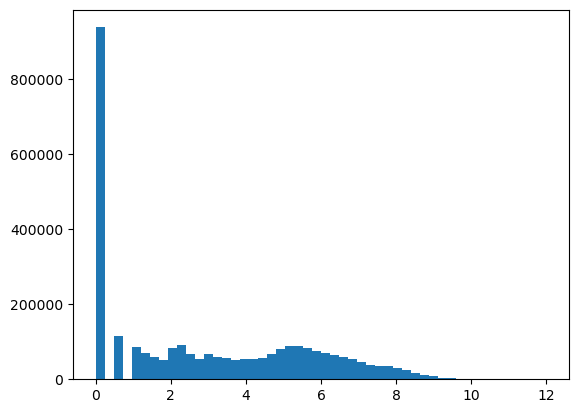

11.73381
tensor(2.6951)
0.0


In [2]:
import matplotlib.pyplot as plt
train_sales_log = np.log(train_sales+1)
data_range = train_sales_log.numpy().max() - train_sales_log.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales_log.numpy().max())+1)
plt.hist(train_sales_log.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(train_sales_log.std())
print(train_sales_log.numpy().min())

In [3]:
print(ids.shape, ids.dtype)
#print(date.shape, date.dtype)
print(train_sales.shape, train_sales.dtype)
print(train_sales_log.shape, train_sales_log.dtype)
print(onpromotion.shape, onpromotion.dtype)
print(family.shape, family.dtype)
print(day_of_week.shape, day_of_week.dtype)
print(month.shape, month.dtype)
print(day_since_paycheck.shape, day_since_paycheck.dtype)

torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.int64
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32


In [4]:
train_data = torch.cat((month.unsqueeze(1), day_of_week.unsqueeze(1),day_since_paycheck.unsqueeze(1),
                           store_nbr.unsqueeze(1), family.unsqueeze(1),  onpromotion.unsqueeze(1), 
                           ), dim=1)

print(train_data.dtype)
print(train_data.shape, train_data.dtype)
print(train_sales.shape, train_sales.dtype)

torch.float32
torch.Size([3000888, 6]) torch.float32
torch.Size([3000888]) torch.float32


In [5]:
# Shuffle the data and labels
indices = np.random.permutation(len(train_data))
train_data = train_data[indices]
train_sales = train_sales_log[indices]

# Define the percentage of data to be used for validation
val_percent = 0.2

# Calculate the number of validation samples
val_size = int(len(train_data) * val_percent)

# Split the data and labels into training and validation sets
val_data = train_data[:val_size]
train_data = train_data[val_size:]

val_sales = train_sales[:val_size]
train_sales = train_sales[val_size:]

print(val_data.shape)
print(val_sales.shape)
print(train_data.shape)
print(train_sales.shape)

torch.Size([600177, 6])
torch.Size([600177])
torch.Size([2400711, 6])
torch.Size([2400711])


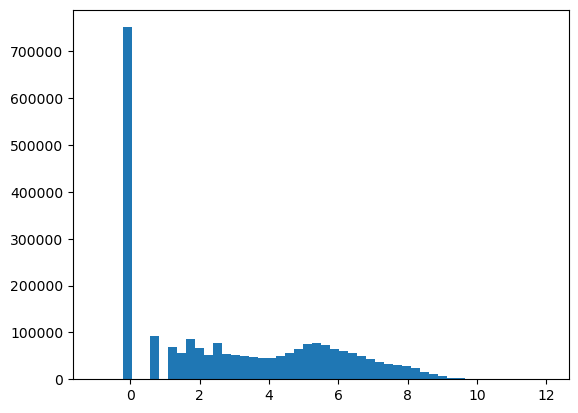

11.73381
std 2.695456027984619
mean 2.9274446964263916
min 0.0
max 11.733810424804688


In [6]:
import matplotlib.pyplot as plt
data_range = train_sales.numpy().max() - train_sales.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (-1, int(train_sales.numpy().max())+1)
plt.hist(train_sales.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(f'std {train_sales.std()}')
print(f'mean {train_sales.mean()}')
print(f'min {train_sales.min()}')
print(f'max {train_sales.max()}')

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [11]:
from torch import nn
import math

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        rmsle = self.mse(torch.log(pred + 1), torch.log(actual + 1)) 
        if (math.isnan(rmsle)):
            #print('pred{:.4f}, actual{:.4f}% \ntorch.log(pred + 1){:.4f},torch.log(actual + 1){:.4f}'.format(pred, actual, torch.log(pred + 1),torch.log(actual + 1)))
            print("NaN problem")
            print(f"pred{pred}")
            print(f"actual{actual}")
        return rmsle


In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SalesPredictor(nn.Module):
    def __init__(self):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(6, 64) 
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1, bias=False)
        self.Leaky_ReLu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.Leaky_ReLu(x)
        x = self.fc3(x)
        x = self.Leaky_ReLu(x)
        x = self.fc4(x)
        x = self.relu(x)
        return x
    
    # Instantiate the neural network
model = SalesPredictor()
print(model)

SalesPredictor(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=False)
  (Leaky_ReLu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
)


In [20]:
from torch.utils.data import TensorDataset, DataLoader
# Define the loss function and optimizer
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters())

# Convert the data and labels to PyTorch datasets
train_dataset = TensorDataset(train_data, train_sales)
val_dataset = TensorDataset(val_data, val_sales)
# Define batch size for training and validation dataloaders
batch_size = 64
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=10)
save_every = 1
train_iterations = 60


In [21]:
#MSE_s = []
running_loss_es = []

In [22]:
# Train the neural network
for epoch in range(train_iterations):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        print (f'{i} of {len(train_loader)}', end = ' \r'),
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(-1)
        outputs = outputs.squeeze(-1)
        
        #returning to real values instead of logs
        labels = torch.exp(labels)+1
        outputs = torch.exp(outputs)+1
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"\nEpoch {epoch} loss: {running_loss/len(train_loader)}")
    running_loss_es.append(running_loss/len(train_loader))
    if (epoch % save_every == 0):
        model_file_name = f'model_weights_{epoch}.pth'
        print(f'Saving model as {model_file_name}')
        torch.save(model, model_file_name)
torch.save(model, f'model_weights_{train_iterations}.pth')

37511 of 37512 
Epoch 0 loss: 2.3318030682199162
Saving model as model_weights_0.pth
37511 of 37512 
Epoch 1 loss: 1.456922132999347
Saving model as model_weights_1.pth
37511 of 37512 
Epoch 2 loss: 1.2833534057752032
Saving model as model_weights_2.pth
37511 of 37512 
Epoch 3 loss: 1.1974815742781444
Saving model as model_weights_3.pth
37511 of 37512 
Epoch 4 loss: 1.1199031776791697
Saving model as model_weights_4.pth
37511 of 37512 
Epoch 5 loss: 1.0759797372487205
Saving model as model_weights_5.pth
37511 of 37512 
Epoch 6 loss: 1.0523541848355773
Saving model as model_weights_6.pth
37511 of 37512 
Epoch 7 loss: 1.028263473111042
Saving model as model_weights_7.pth
37511 of 37512 
Epoch 8 loss: 1.0121326676239577
Saving model as model_weights_8.pth
37511 of 37512 
Epoch 9 loss: 0.9956058915335059
Saving model as model_weights_9.pth
37511 of 37512 
Epoch 10 loss: 0.9824405986903878
Saving model as model_weights_10.pth
37511 of 37512 
Epoch 11 loss: 0.9709127635076741
Saving model as

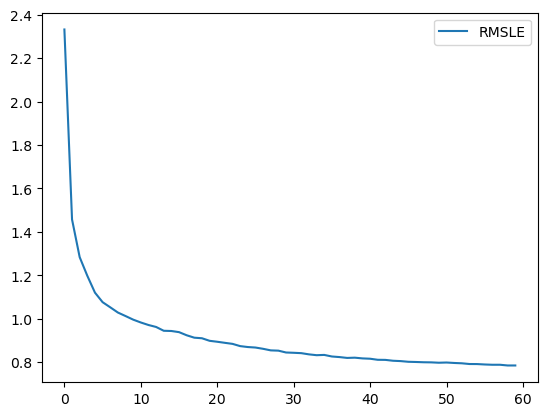

In [23]:
import matplotlib.pyplot as plt # for making figures
plt.plot(running_loss_es, label = "RMSLE")
plt.legend()

In [24]:
for param in model.parameters():
    print(param.data)

tensor([[-5.7437e-02, -1.5084e-02,  4.9845e-02,  5.0964e-03, -1.1841e-03,
         -1.3683e-03],
        [ 2.1367e-02, -3.3556e-02, -1.1001e-03, -7.2602e-03, -1.8133e-02,
         -1.8000e-02],
        [-2.5149e-03,  4.3017e-03, -6.6710e-03, -3.0078e-01, -5.4626e-01,
         -1.6470e-02],
        [ 1.8272e-02,  3.2212e-02, -9.7213e-03, -2.0519e+00,  6.1024e-02,
         -3.9052e-03],
        [ 8.7555e-03, -1.2920e-02,  4.9951e-03,  2.1940e-01,  2.3307e-01,
          6.6840e-04],
        [ 8.5935e-03,  1.4071e-03, -2.3236e-03, -8.1921e-01,  5.4317e-01,
          4.1056e-02],
        [-5.1964e-01, -2.3234e+00, -1.4818e+00, -6.3818e-01, -8.3138e-01,
          8.5785e-02],
        [-1.2612e-02, -2.2765e-02, -1.0424e-02, -6.1422e-02,  5.8962e-01,
         -5.8697e+00],
        [ 4.3825e-02,  2.2340e-01, -3.0713e-01,  4.7302e-02, -1.4516e-02,
         -2.1604e-02],
        [ 1.6238e-02, -1.3257e-02,  3.0975e-03,  1.8809e-01, -2.0424e+00,
         -2.5146e-03],
        [-2.5855e-02,  5.5257e

In [27]:
# Set the model to evaluation mode
model.eval()
machine_epsilon = 1
# Initialize the total loss and accuracy
total_loss = 0
total_correct = 0
total_samples = 0
machine_epsilon = train_sales_log.std()/10 
# Disable gradient calculation
with torch.no_grad():
    # Loop over the validation set
    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_labels = batch_labels.squeeze(-1)
        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        
        batch_labels = torch.exp(batch_labels)+1
        outputs = torch.exp(outputs)+1
        
        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        # Accumulate the loss
        total_loss += loss.item() * batch_data.size(0)

        # Get the predicted class
        
        
        # Count the number of correct predictions
        total_correct += ((
            (outputs - batch_labels)**2)<machine_epsilon).sum().item()

        # Increment the total number of samples
        total_samples += batch_data.size(0)
        #break
# Calculate the average loss and accuracy over the validation set
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

# Print the results
print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(average_loss, accuracy * 100))

Validation Loss: 0.7872, Validation Accuracy: 17.36%


In [34]:
def evaluate(model_file, val_loader):
    # Load the neural network from file
    model = torch.load(model_file)
    print('Testing model ' + model_file)
    # Get the name of the model
    model_name = model_file.split("/")[-1]
    
    # Evaluate the neural network on the testing set
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            # Loop over the validation set
        for batch_data, batch_labels in val_loader:
            # Move the data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_data)
            outputs = outputs.squeeze(-1)
            #batch_labels = torch.squeeze(-1)
            
            batch_labels = torch.exp(batch_labels)+1
            outputs = torch.exp(outputs)+1
        

            # Calculate the loss
            loss = criterion(outputs, batch_labels)
            
            # Accumulate the loss
            total_loss += loss.item() * batch_data.size(0)

            # Get the predicted class
            # Count the number of correct predictions
            total_correct += (
                    ((outputs - batch_labels)**2)<machine_epsilon).sum().item()
    
            # Increment the total number of samples
            total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
    average_loss = total_loss / total_samples
    #accuracy = total_correct / total_samples

# Print the results
    #accuracy = 0
    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(average_loss, accuracy * 100))
    return average_loss

In [35]:
val_loss = []
for i in range(train_iterations):
    if (i % save_every == 0):
        #print(i)
        val_loss.append(evaluate(f'model_weights_{i}.pth',val_loader))

Testing model model_weights_0.pth
Validation Loss: 1.7254, Validation Accuracy: 17.36%
Testing model model_weights_1.pth
Validation Loss: 1.2161, Validation Accuracy: 17.36%
Testing model model_weights_2.pth
Validation Loss: 1.2710, Validation Accuracy: 17.36%
Testing model model_weights_3.pth
Validation Loss: 1.2364, Validation Accuracy: 17.36%
Testing model model_weights_4.pth
Validation Loss: 1.1096, Validation Accuracy: 17.36%
Testing model model_weights_5.pth
Validation Loss: 1.3051, Validation Accuracy: 17.36%
Testing model model_weights_6.pth
Validation Loss: 0.9796, Validation Accuracy: 17.36%
Testing model model_weights_7.pth
Validation Loss: 1.0064, Validation Accuracy: 17.36%
Testing model model_weights_8.pth
Validation Loss: 0.9724, Validation Accuracy: 17.36%
Testing model model_weights_9.pth
Validation Loss: 0.9365, Validation Accuracy: 17.36%
Testing model model_weights_10.pth
Validation Loss: 0.9407, Validation Accuracy: 17.36%
Testing model model_weights_11.pth
Validat

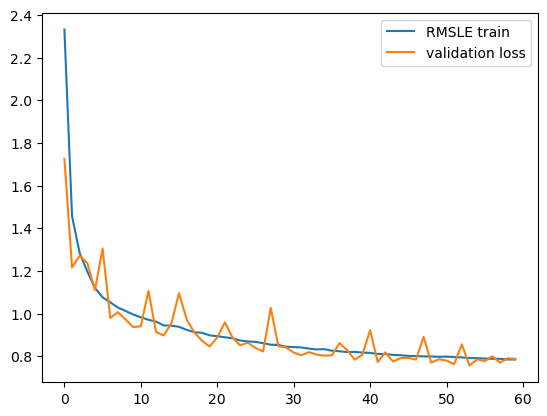

In [36]:
plt.plot(running_loss_es, label = "RMSLE train")
plt.plot(val_loss, label = "validation loss")
plt.legend()

In [38]:
!systemctl suspend

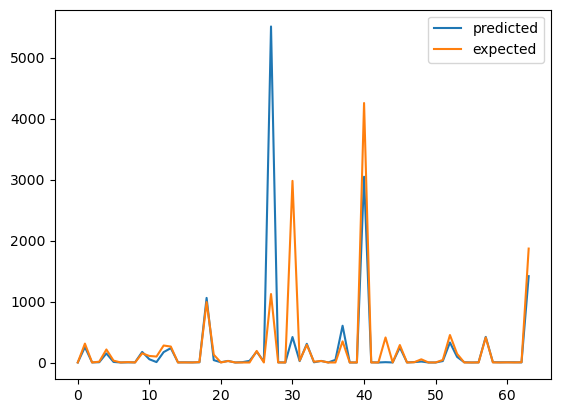

In [54]:
with torch.no_grad():

    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        #batch_labels = torch.squeeze(-1)

        batch_labels = torch.exp(batch_labels)+1
        outputs = torch.exp(outputs)+1


        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        plt.plot(outputs.numpy(), label = "predicted")
        plt.plot(batch_labels.numpy(), label = "expected")
        plt.legend()
        break

loss = 0.7519540786743164


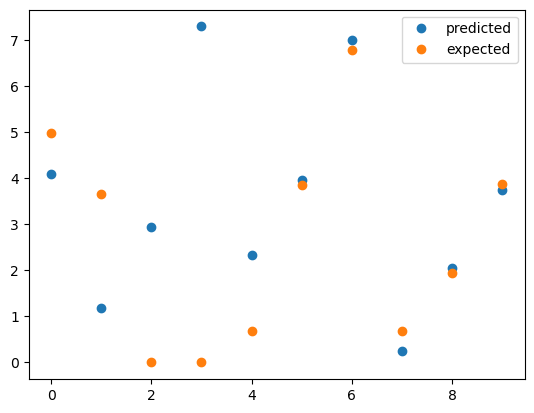

In [79]:
with torch.no_grad():
    evalutaion_val_dataset = val_loader.dataset
    n_samples = len(evalutaion_val_dataset)
    outputs = []
    expections = []
    for i in range(10):
    # Get a random sample
        random_index = int(np.random.random()*n_samples)
        single_example = evalutaion_val_dataset[random_index]
        output = model(single_example[0])
        outputs.append(output)
        expections.append(single_example[1])
        
    loss = criterion(torch.FloatTensor(outputs).squeeze(-1), torch.FloatTensor(expections).squeeze(-1))
    plt.plot(outputs, label = "predicted", linestyle="",marker="o")
    plt.plot(expections, label = "expected", linestyle="",marker="o")
    plt.legend()
    print(f'loss = {loss}')


In [60]:
evaluate(f'model_weights_32.pth',val_loader)

Testing model model_weights_32.pth
Validation Loss: 0.7605, Validation Accuracy: 0.00%


0

In [37]:
a = torch.rand(5)
b = torch.rand(5)
for i in range(len(a)):
    a[i] = 0
    b[i] = 0
print(a)
print(b)
criterion(a,b)

tensor([0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0.])


tensor(0.)